# Libraries

In [1]:
# !pip install awkward
# !pip install uproot
# !pip install vector
# !pip install requests
# !pip install torch
# !pip install tqdm
# !pip install fairseq
# !pip install tensorboardX

In [4]:
# to include the files that has modified ParticleTransformer class for quantization

import sys
if '/part-vol-2/weaver-core/particle_transformer/notebooks/Efficient-Transformer-Tests' not in sys.path:
    sys.path.append('/part-vol-2/weaver-core/particle_transformer/notebooks/Efficient-Transformer-Tests')

In [5]:
# importing libraries and modified ParticleTransformer class for quantization

import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm
import torch
#from weaver.nn.model.ParticleTransformer import ParticleTransformer
from ParticleTransformer_updated import ParticleTransformer
from ParticleTransformer_updated_quant_weights import ParticleTransformer as ParticleTransformer_quant
from weaver.utils.logger import _logger
import torch.optim as optim
import time


# Importing data

In [6]:
# importing data

def build_features_and_labels(tree, transform_features=True):
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log', 
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)
    
    return out

def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))
    
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


tree = uproot.open('/part-vol-2/weaver-core/particle_transformer/notebooks/JetClass_example_100k.root')['tree']

table = build_features_and_labels(tree)

In [7]:
# creating data

x_particles = table['pf_features']
x_jets = table['pf_vectors']
y = table['label']
x_points = table['pf_points']
x_mask = table['pf_mask']

r_indexes = np.arange(len(x_particles))
np.random.shuffle(r_indexes)

# train
a = 100000
x_particles_train=x_particles[r_indexes][0:a]
x_jets_train=x_jets[r_indexes][0:a]
y_train=y[r_indexes][0:a]
x_points_train=x_points[r_indexes][0:a]
x_mask_train=x_mask[r_indexes][0:a]

# test
a = 500
x_part_test=x_particles[r_indexes][20000:20000 + a]
x_jet_test=x_jets[r_indexes][20000:20000 + a]
y_test=y[r_indexes][20000:20000 + a]
x_points_test=x_points[r_indexes][20000:20000 + a]
x_mask_test=x_mask[r_indexes][20000:20000 + a]

# Importing models

In [8]:
# Actual ParticleTransformer model

class ParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = ParticleTransformer(**kwargs)
        self.attention_matrix = None 
        self.interactionMatrix = None
    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        output = self.mod(features, v=lorentz_vectors, mask=mask)
        self.attention_matrix = self.mod.getAttention()
        self.interactionMatrix = self.mod.getInteraction()
        return output
        
    def get_attention_matrix(self):
        return self.attention_matrix
    def get_interactionMatrix(self):
        return self.interactionMatrix

# me 

def get_model(**kwargs):

    cfg = dict(
        input_dim=17,
        num_classes=10,
        # network configurations
        pair_input_dim=4,
        use_pre_activation_pair=False,
        embed_dims=[128, 512, 128],
        pair_embed_dims= [64,64,64],
        num_heads=8,
        num_layers=8,      # make it 8 
        num_cls_layers=2,
        block_params=None,
        cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
        fc_params=[],
        activation='gelu',
        # misc
        trim=True,
        for_inference=False,
    )
    cfg.update(**kwargs)
    _logger.info('Model config: %s' % str(cfg))

    model = ParticleTransformerWrapper(**cfg)

    model_info = {
    }

    return model, model_info

base_model, _ = get_model()

base_model

2024-08-24 20:15:53 | INFO | weaver | Model config: {'input_dim': 17, 'num_classes': 10, 'pair_input_dim': 4, 'use_pre_activation_pair': False, 'embed_dims': [128, 512, 128], 'pair_embed_dims': [64, 64, 64], 'num_heads': 8, 'num_layers': 8, 'num_cls_layers': 2, 'block_params': None, 'cls_block_params': {'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0}, 'fc_params': [], 'activation': 'gelu', 'trim': True, 'for_inference': False}
2024-08-24 20:15:53 | INFO | weaver | cfg_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0.1, 'attn_dropout': 0.1, 'activation_dropout': 0.1, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}
2024-08-24 20:15:53 | INFO | weaver | cfg_cls_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scal

ParticleTransformerWrapper(
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17, out_features=128, bias=True)
        (2): GELU(approximate='none')
        (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (4): Linear(in_features=128, out_features=512, bias=True)
        (5): GELU(approximate='none')
        (6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (7): Linear(in_features=512, out_features=128, bias=True)
        (8): GELU(approximate='none')
      )
    )
    (pair_embed): PairEmbed(
      (embed): Sequential(
        (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(64, eps=

In [9]:
# Quantizable ParticleTransformer model


class ParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = ParticleTransformer_quant(**kwargs)
        self.attention_matrix = None 
        self.interactionMatrix = None
    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        output = self.mod(features, v=lorentz_vectors, mask=mask)
        self.attention_matrix = self.mod.getAttention()
        self.interactionMatrix = self.mod.getInteraction()
        return output
        
    def get_attention_matrix(self):
        return self.attention_matrix
    def get_interactionMatrix(self):
        return self.interactionMatrix
    
def get_model(**kwargs):

    cfg = dict(
        input_dim=17,
        num_classes=10,
        # network configurations
        pair_input_dim=4,
        use_pre_activation_pair=False,
        embed_dims=[128, 512, 128],
        pair_embed_dims= [64,64,64],
        num_heads=8,
        num_layers=8,      # make it 8 
        num_cls_layers=2,
        block_params=None,
        cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
        fc_params=[],
        activation='gelu',
        # misc
        trim=True,
        for_inference=False,
    )
    cfg.update(**kwargs)
    _logger.info('Model config: %s' % str(cfg))

    model = ParticleTransformerWrapper(**cfg)

    model_info = {
    }

    return model, model_info

pre_trained_model_quant, _ = get_model()

pre_trained_model_quant

2024-08-24 20:15:54 | INFO | weaver | Model config: {'input_dim': 17, 'num_classes': 10, 'pair_input_dim': 4, 'use_pre_activation_pair': False, 'embed_dims': [128, 512, 128], 'pair_embed_dims': [64, 64, 64], 'num_heads': 8, 'num_layers': 8, 'num_cls_layers': 2, 'block_params': None, 'cls_block_params': {'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0}, 'fc_params': [], 'activation': 'gelu', 'trim': True, 'for_inference': False}
2024-08-24 20:15:54 | INFO | weaver | cfg_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0.1, 'attn_dropout': 0.1, 'activation_dropout': 0.1, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}
2024-08-24 20:15:54 | INFO | weaver | cfg_cls_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scal

ParticleTransformerWrapper(
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17, out_features=128, bias=True)
        (2): GELU(approximate='none')
        (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (4): Linear(in_features=128, out_features=512, bias=True)
        (5): GELU(approximate='none')
        (6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (7): Linear(in_features=512, out_features=128, bias=True)
        (8): GELU(approximate='none')
      )
    )
    (pair_embed): PairEmbed(
      (embed): Sequential(
        (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(64, eps=

In [10]:
# setting the loss function and test data

loss_fn = torch.nn.CrossEntropyLoss()
inp = torch.from_numpy(x_points_test),torch.from_numpy(x_part_test),torch.from_numpy(x_jet_test),torch.from_numpy(x_mask_test)


# Loading pretrained weights

In [11]:
# loading weights in the Actual ParticleTransformer model

# Load the pretrained weights from the .pt file
pretrained_dict = torch.load("/part-vol-2/weaver-core/particle_transformer/models/ParT_full.pt")
print('pretrained_dict', pretrained_dict.keys())
# Load only the parameters that exist in the model
model_dict = base_model.state_dict()
print('model_dict', model_dict.keys())

#pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}    # maybe change 
model_dict.update(pretrained_dict)
print('model_dict', model_dict.keys())

base_model.load_state_dict(model_dict)
print('pre_trained_model final', base_model.state_dict().keys())

# # Set the model to evaluation mode
# pre_trained_model.eval()

pretrained_dict odict_keys(['mod.cls_token', 'mod.embed.input_bn.weight', 'mod.embed.input_bn.bias', 'mod.embed.input_bn.running_mean', 'mod.embed.input_bn.running_var', 'mod.embed.input_bn.num_batches_tracked', 'mod.embed.embed.0.weight', 'mod.embed.embed.0.bias', 'mod.embed.embed.1.weight', 'mod.embed.embed.1.bias', 'mod.embed.embed.3.weight', 'mod.embed.embed.3.bias', 'mod.embed.embed.4.weight', 'mod.embed.embed.4.bias', 'mod.embed.embed.6.weight', 'mod.embed.embed.6.bias', 'mod.embed.embed.7.weight', 'mod.embed.embed.7.bias', 'mod.pair_embed.embed.0.weight', 'mod.pair_embed.embed.0.bias', 'mod.pair_embed.embed.0.running_mean', 'mod.pair_embed.embed.0.running_var', 'mod.pair_embed.embed.0.num_batches_tracked', 'mod.pair_embed.embed.1.weight', 'mod.pair_embed.embed.1.bias', 'mod.pair_embed.embed.2.weight', 'mod.pair_embed.embed.2.bias', 'mod.pair_embed.embed.2.running_mean', 'mod.pair_embed.embed.2.running_var', 'mod.pair_embed.embed.2.num_batches_tracked', 'mod.pair_embed.embed.4.we

In [12]:
# loading weights in the Quantizable ParticleTransformer model

pretrained_dict = torch.load("/part-vol-2/weaver-core/particle_transformer/models/ParT_full.pt")

def adapt_weights(pretrained_dict):
    new_dict = {}
    for key, value in pretrained_dict.items():
        if 'attn.in_proj_weight' in key:
            # Split the original in_proj_weight into Q, K, V
            q, k, v = torch.chunk(value, 3, dim=0)
            base_key = key.replace('in_proj_weight', 'linear_Q.weight')
            new_dict[base_key] = q
            new_dict[base_key.replace('linear_Q', 'linear_K')] = k
            new_dict[base_key.replace('linear_Q', 'linear_V')] = v
        elif 'attn.in_proj_bias' in key:
            # Split the original in_proj_bias into Q, K, V
            q, k, v = torch.chunk(value, 3, dim=0)
            base_key = key.replace('in_proj_bias', 'linear_Q.bias')
            new_dict[base_key] = q
            new_dict[base_key.replace('linear_Q', 'linear_K')] = k
            new_dict[base_key.replace('linear_Q', 'linear_V')] = v
        else:
            new_dict[key] = value
    return new_dict

adapted_weights = adapt_weights(pretrained_dict)


model_dict = pre_trained_model_quant.state_dict()
model_dict.update(adapted_weights)  # Update the model's state dict with the adapted weights
pre_trained_model_quant.load_state_dict(model_dict)

pre_trained_model_quant

ParticleTransformerWrapper(
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17, out_features=128, bias=True)
        (2): GELU(approximate='none')
        (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (4): Linear(in_features=128, out_features=512, bias=True)
        (5): GELU(approximate='none')
        (6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (7): Linear(in_features=512, out_features=128, bias=True)
        (8): GELU(approximate='none')
      )
    )
    (pair_embed): PairEmbed(
      (embed): Sequential(
        (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(64, eps=

# Comparing the raw vs quantizable model performance

In [13]:
# compare the raw vs quantizable model performance

print('for data size: ', inp[0].shape)

base_model.eval()
with torch.no_grad():
    y_pred= base_model(*inp)

yloss = loss_fn(y_pred.float(), torch.from_numpy(y_test).float())
print('model loss', yloss)

pre_trained_model_quant.eval()
with torch.no_grad():
    y_pred_quant= pre_trained_model_quant(*inp)

yloss_quant = loss_fn(y_pred_quant.float(), torch.from_numpy(y_test).float())
print('Quantized model loss', yloss_quant)


for data size:  torch.Size([500, 2, 128])


/part-vol-2/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


model loss tensor(0.3651)
Quantized model loss tensor(0.3651)


# Training from scratch

In [ ]:
# loading training data

from torch.utils.data import Dataset, DataLoader

learning_rate = 1e-4
dataloader = DataLoader(x_particles_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
ydataloader = DataLoader(y_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xjdataloader = DataLoader(x_jets_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xpointloader = DataLoader(x_points_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xmaskloader = DataLoader(x_mask_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)


In [ ]:
# training

model = pre_trained_model_quant, None


# ??
# total_params = sum(p.numel() for p in model[0].parameters())
# print(total_params)
# model

# model[0].aux_logits=False

epochs = 1 
trainloss = np.zeros(epochs)
valloss = np.zeros(epochs)
optimizer = optim.Adam(model[0].parameters(), lr=0.0001)

for t in range(epochs):
    for x,y,z,a,b in zip(dataloader, ydataloader, xjdataloader,xpointloader,xmaskloader):
        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __c|all__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        model[0].train()
        y_pred = model[0](a.float(), x.float(), z.float(), b.float())
        #print(y_pred.shape)
        
        loss = loss_fn(y_pred, y.float())
        

        # Zero the gradients before running the backward pass.
        model[0].zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        trainloss[t] = loss
        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        optimizer.step()
    with torch.no_grad():
        y_pred= model[0](torch.from_numpy(x_points_test),torch.from_numpy(x_part_test),torch.from_numpy(x_jet_test),torch.from_numpy(x_mask_test))
    yloss = loss_fn(y_pred.float(), torch.from_numpy(y_test).float())
    valloss[t] = yloss
    print('Epoch' +' ' +str(t+1) + ' Train Loss:' +str(trainloss[t]))
    print('        ' + 'Val Loss:' + str(valloss[t]))

# Dynamic Quantization using quantiizable ParticleTransformer

In [14]:
# Setting the function

pre_trained_model = pre_trained_model_quant

pretrained_quantized_model = torch.quantization.quantize_dynamic(
    pre_trained_model, {torch.nn.Linear}, dtype=torch.qint8
)

In [15]:
# Comparing the model sizes

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(base_model)
print_size_of_model(pre_trained_model)
print_size_of_model(pretrained_quantized_model)

Size (MB): 8.639375
Size (MB): 10.640995
Size (MB): 4.385699


Size (MB): 8.639375
Size (MB): 10.640995
Size (MB): 4.385699


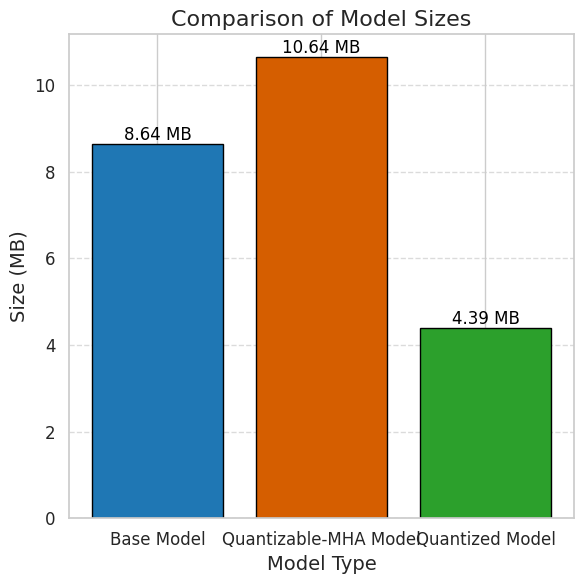

In [30]:
# plotting model size reduction

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Calculate sizes for models
base_model_size = print_size_of_model(base_model)
pre_trained_model_size = print_size_of_model(pre_trained_model)
pretrained_quantized_model_size = print_size_of_model(pretrained_quantized_model)

# Data for plotting
sizes = [base_model_size, pre_trained_model_size, pretrained_quantized_model_size]
labels = ['Base Model', 'Quantizable-MHA Model', 'Quantized Model']

# Set the style
sns.set(style="whitegrid")

# Plottingimport torch
import os
import matplotlib.pyplot as plt
import seaborn as sns

def get_size_of_model(model):
    temp_path = "temp.p"
    torch.save(model.state_dict(), temp_path)
    size_mb = os.path.getsize(temp_path) / 1e6
    os.remove(temp_path)
    return size_mb

# Calculate sizes for models
base_model_size = get_size_of_model(base_model)
pre_trained_model_size = get_size_of_model(pre_trained_model)
pretrained_quantized_model_size = get_size_of_model(pretrained_quantized_model)

# Data for plotting
sizes = [base_model_size, pre_trained_model_size, pretrained_quantized_model_size]
labels = ['Base Model', 'Quantizable-MHA Model', 'Quantized Model']

# Set the style
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(6, 6))
bars = plt.bar(labels, sizes, color=['#1f77b4', '#d55e00', '#2ca02c'], edgecolor='black')

# Adding value annotations on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f} MB', va='bottom', ha='center', fontsize=12, color='black')

plt.xlabel('Model Type', fontsize=14)
plt.ylabel('Size (MB)', fontsize=14)
plt.title('Comparison of Model Sizes', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()




In [24]:
# loss and inference time comparison

base_model.eval()
with torch.no_grad():
    print('for data size: ', inp[0].shape)
    eval_start_time = time.time()
    y_pred= base_model(*inp)
    eval_end_time = time.time()

yloss = loss_fn(y_pred.float(), torch.from_numpy(y_test).float())
print('model loss', yloss)
print('model inference time', eval_end_time - eval_start_time)

pre_trained_model.eval()
with torch.no_grad():
    print('for data size: ', inp[0].shape)
    eval_start_time_p = time.time()
    y_pred= pre_trained_model(*inp)
    eval_end_time_p = time.time()

yloss = loss_fn(y_pred.float(), torch.from_numpy(y_test).float())
print('model loss', yloss)
print('model inference time', eval_end_time_p - eval_start_time_p)

pretrained_quantized_model.eval()
with torch.no_grad():
    eval_start_time_q = time.time()
    y_pred_quant = pretrained_quantized_model(*inp)
    eval_end_time_q = time.time()

yloss_quant = loss_fn(y_pred_quant.float(), torch.from_numpy(y_test).float())
print('quantized_model loss', yloss_quant)
print ('quantized model inference time', eval_end_time_q - eval_start_time_q)

for data size:  torch.Size([500, 2, 128])


/part-vol-2/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


model loss tensor(0.3651)
model inference time 5.362913370132446
for data size:  torch.Size([500, 2, 128])
model loss tensor(0.3651)
model inference time 5.22483229637146
quantized_model loss tensor(0.3648)
quantized model inference time 4.85134220123291


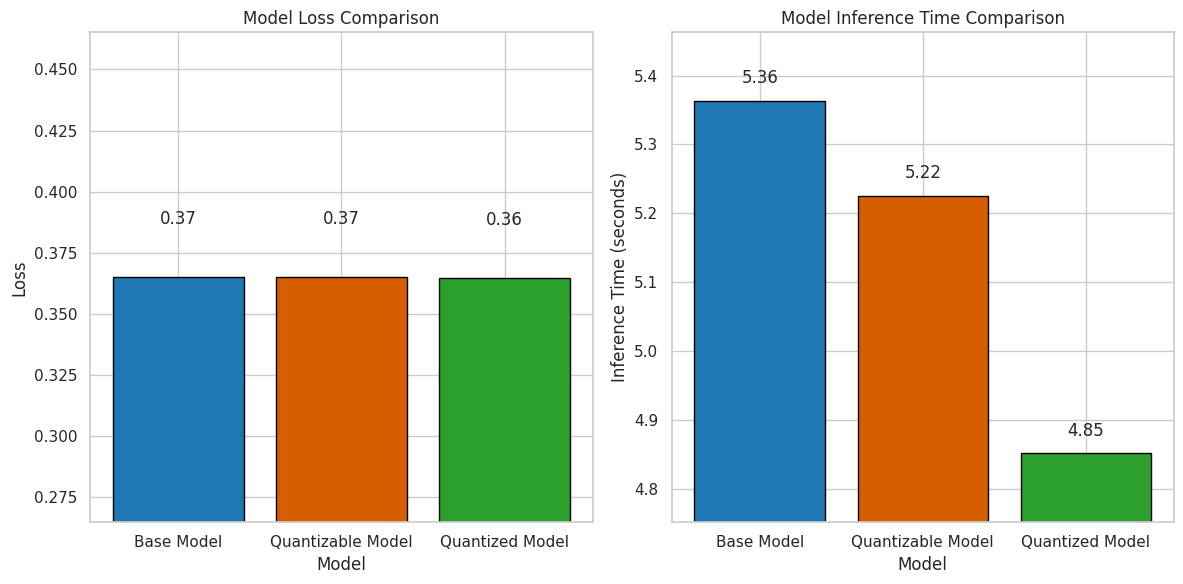

In [25]:

# Initialize lists to store results
models = ['Base Model', 'Quantizable Model', 'Quantized Model']
losses = []
inference_times = []

losses.append(yloss.item())
inference_times.append(eval_end_time - eval_start_time)

losses.append(yloss.item())
inference_times.append(eval_end_time_p - eval_start_time_p)

losses.append(yloss_quant.item())
inference_times.append(eval_end_time_q - eval_start_time_q)

# Define colors for the bars
colors = ['#1f77b4', '#d55e00', '#2ca02c']  # Blue for base, dark orange for quantizable, green for quantized

# Plot losses
plt.figure(figsize=(12, 6))

# Losses
plt.subplot(1, 2, 1)
bars = plt.bar(models, losses, color=colors, edgecolor='black')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.ylim(min(losses) - 0.1, max(losses) + 0.1)  # Adjust y-axis limits for better visibility

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

# Inference times
plt.subplot(1, 2, 2)
bars = plt.bar(models, inference_times, color=colors, edgecolor='black')
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Model Inference Time Comparison')
plt.ylim(min(inference_times) - 0.1, max(inference_times) + 0.1)  # Adjust y-axis limits for better visibility

# Add text annotations
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

#label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
label_list = ['label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']

def makeRoc(y_pred, labels_val, labels, model, model_type, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    if model_type == 'original':
        labels_pred = y_pred
    elif model_type == 'quantized':
        labels_pred = y_pred.dequantize()
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    g = labels_pred.detach().numpy()
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = g[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([0.0001,1.05])
    plt.ylim(0.0001,1.05)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'Particle Transformer ROC Curve ' + model_type,fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    #return labels_pred


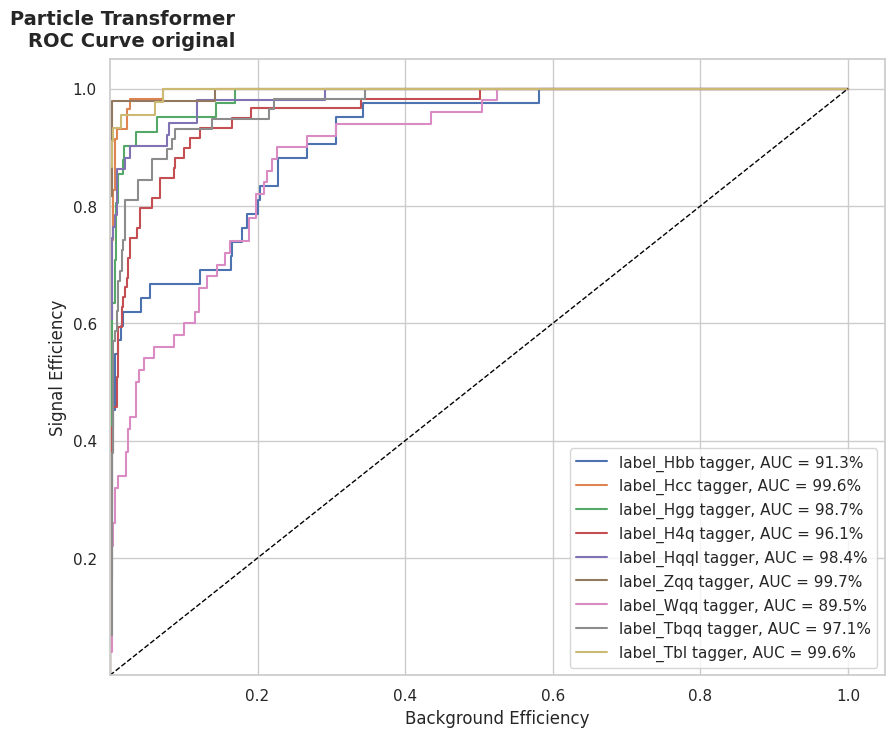

In [21]:
makeRoc(y_pred, y_test, label_list, pre_trained_model, 'original')

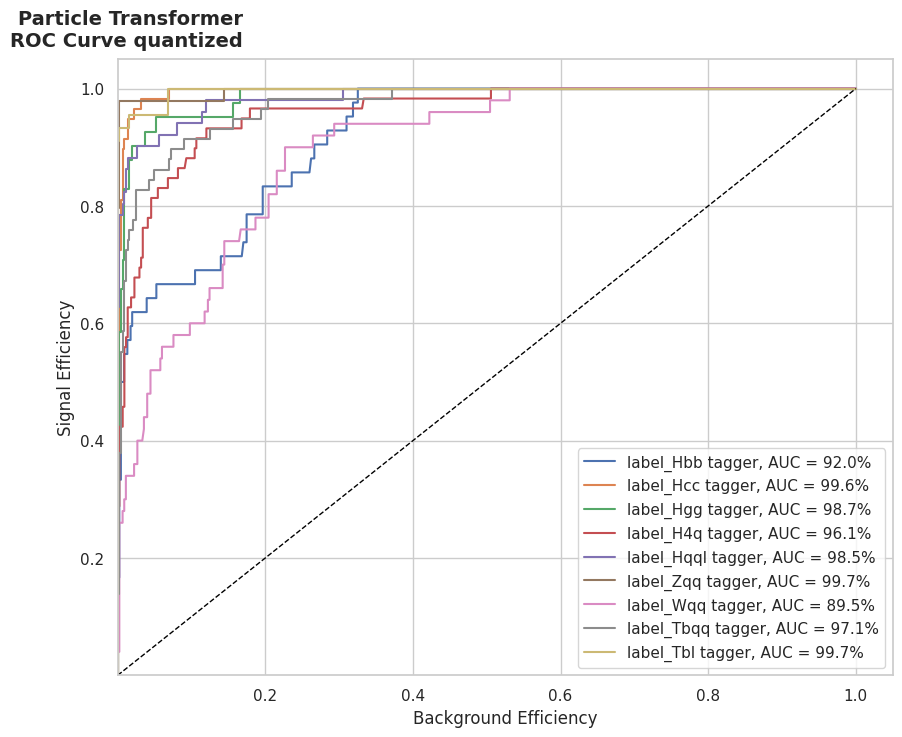

In [22]:
makeRoc(y_pred_quant, y_test, label_list, pretrained_quantized_model, 'quantized')

In [23]:
import numpy as np
from sklearn.metrics import roc_curve

n_classes = 10
y_prob = y_pred
y_prob_quant = y_pred_quant

fpr_at_50_tpr = []
fpr_at_50_tpr_quant = []

for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_prob[:, i])
    fpr_quant, tpr_quant, thresholds_quant = roc_curve(y_test[:, i], y_prob_quant[:, i])
    
    idx = np.abs(tpr - 0.5).argmin()
    idx_quant = np.abs(tpr_quant - 0.5).argmin()
    fpr_at_50_tpr.append(fpr[idx])
    fpr_at_50_tpr_quant.append(fpr_quant[idx_quant])
    print(f"Class {i} | ParT: TPR = 50% -> FPR = {fpr[idx]} | Quantized: TPR = 50% -> FPR = {fpr_quant[idx_quant]} |")

average_fpr = np.mean(fpr_at_50_tpr)
average_fpr_quant = np.mean(fpr_at_50_tpr_quant)
print(f"Average Background Rejection at TPR = 50% across all classes | ParT: {1/average_fpr} | Quantized: {1/average_fpr_quant} ")


Class 0 | ParT: TPR = 50% -> FPR = 0.004366812227074236 | Quantized: TPR = 50% -> FPR = 0.004366812227074236 |
Class 1 | ParT: TPR = 50% -> FPR = 0.0 | Quantized: TPR = 50% -> FPR = 0.0 |
Class 2 | ParT: TPR = 50% -> FPR = 0.0 | Quantized: TPR = 50% -> FPR = 0.002178649237472767 |
Class 3 | ParT: TPR = 50% -> FPR = 0.009070294784580499 | Quantized: TPR = 50% -> FPR = 0.009070294784580499 |
Class 4 | ParT: TPR = 50% -> FPR = 0.0 | Quantized: TPR = 50% -> FPR = 0.0 |
Class 5 | ParT: TPR = 50% -> FPR = 0.0 | Quantized: TPR = 50% -> FPR = 0.0 |
Class 6 | ParT: TPR = 50% -> FPR = 0.035555555555555556 | Quantized: TPR = 50% -> FPR = 0.04 |
Class 7 | ParT: TPR = 50% -> FPR = 0.004524886877828055 | Quantized: TPR = 50% -> FPR = 0.004524886877828055 |
Class 8 | ParT: TPR = 50% -> FPR = 0.0 | Quantized: TPR = 50% -> FPR = 0.0 |
Class 9 | ParT: TPR = 50% -> FPR = 0.0 | Quantized: TPR = 50% -> FPR = 0.0 |
Average Background Rejection at TPR = 50% across all classes | ParT: 186.85459449651813 | Qua